# Building a JAX ray marching rendering engine
7/14/20
<br/>
<br/>
<br/>

I've recently fallen into a computer graphics rabbit hole, trying to understand how modern rendering systems work. I use GPUs all the time for work but mainly for machine learning workloads and I've always been curious about what exactly makes them useful for computer graphics. However, I've always lacked the fundamental knowledge of the algorithms and methods used in computer graphics.

After reading a bunch of papers and blogs, and binging several YouTube channels about ray tracers and shaders, I think I better understand how some of the important algorithms work, but implementing something will be the real test.
So, in this inaugural blog post, I'd like to build a renderer from scratch, specifically a *ray marcher*.

A quick note: inspired by the documentation on [www.tensorflow.org](), I've decided to write this blog post in [Colab](https://colab.research.google.com/). This way the code is all there for you to read and you can even run it yourself using the link below.
<table class="notebook-buttons">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/sharadvikram.com/blob/master/public/Ray_Marching_Blog_Post.ipynb""><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/sharadmv/sharadvikram.com/blob/master/public/Ray_Marching_Blog_Post.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Okay, let's dive right into it.

## Background
Broadly speaking, rendering is the process of converting a scene (an abstract collection of objects, lights, textures, etc.) into an image. There are many rendering algorithms but in this post we'll focus on one I found particularly interesting: *ray marching*.

But before we dive into ray marching, let's first discuss what exactly it is we are rendering, namely a *scene*. When you take a picture with a camera, you are capturing photons of varying wavelengths that represent colors. A simple mental model for these photons is that they originated from a set of light sources. (This isn't always true, since photons can be created and absorbed when they hit objects.) Take a light source like the sun, for example. The sun emits many many photons that refract, reflect, and scatter all over the place until they reach your camera. By the time a photon reaches your camera, it's possible it has a different wavelength and different color from the light source it was emitted from. 

Although photons are really emitted by the sun and eventually make their way to the camera, a ray tracer reverses the process and follows their path backwards away from the camera. The basic idea is that we shoot out several "rays" from the camera. Each ray follows the path of a photon backwards and the color of the pixel is computed from the resulting path. In the following image, we can see

<center>

| <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Ray_trace_diagram.svg/1920px-Ray_trace_diagram.svg.png" width="400"/> | 
|:--:| 
| A ray tracer emits rays from the camera and computes the color of each pixel from the path of the ray. Image from [Wikipedia](https://en.wikipedia.org/wiki/Ray_tracing_(graphics)).|

</center>

**Ray marching** is an algorithm that does exactly this: it "marches" rays out of the camera, bouncing off objects and computing a color for its corresponding pixel. Marching specifically refers to the iterative updating the position of the ray, as opposed to computing intersection points with objects.

#### Using JAX

Before we dive into some code, it's worth quickly mentioning the library we'll be using: [JAX](https://github.com/google/jax). JAX is a Python library for numerical computation based on functional programming and composable function transformations. JAX is cool because it can differentiate NumPy-like code, and have it run on the GPU with no additional effort. I'd recommend you check out the [JAX quickstart](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html) if you are interested.

### Setup
Let's install our dependencies. We'll also set up some type variables that aren't particularly useful for type checking but will make our function signatures a bit more readable.

In [47]:
!pip install jax jaxlib --upgrade -q


In [48]:
import abc
from functools import partial
from typing import Any, List

import dataclasses
import jax
from jax import jit, vmap, grad, lax
import jax.numpy as jnp
import matplotlib.pyplot as plt

Vector = Point = Color = Scalar = Image = Any

### Utilities

Before we dive into the ray marching algorithm, let's first write some basic functions and abstractions that we'll use later on.

First we'll write some utility functions that will convenient for later code. We'll be representing colors with length-3 RGB vectors containing a value from \[0, 1\]. The vector \[1, 0, 0\] represents pure red and \[1, 1, 1\] is white.

In [49]:
def normalize(x: Vector) -> Vector:
  """Normalizes a vector."""
  return x / jnp.linalg.norm(x)
  
def color_from_hex(x: str) -> Color:
  """Converts a hex string to a [0, 1] color vector."""
  return jnp.array([int(x[1:3], 16), int(x[3:5], 16), int(x[5:], 16)]) / 255.

When we construct a scene with objects, we'll need to define some properties of the objects that influence how light interacts with them. The simplest property of an object is its color, but we'll also define some additional properties (`diffuse`, `specular`, `reflection`) that will also be important later.

We can use a `dataclass` to make our definition concise, and we'll make the default color red.

In [50]:
@dataclasses.dataclass
class Material:
  color: Color = color_from_hex('#FF0000')
  diffuse: float = 1.0
  specular: float = 1.0
  reflection: float = 0.1

## Ray marching

So previously I described ray marching as an algorithm that iteratively updates the position of rays until they collide with objects. Recall that a ray is a point $p$ and a vector $v$, corresponding to a position and a direction. We could imagine picking a step size $\rho$ and updating the position of the vector $p_{t + 1} = p_t + \rho v$ and after every update, check that we have collided with an object in the scene.

This algorithm is pretty problematic however; if we pick too small of a $\rho$, we will take way too many steps to actually collide with an object but with too big a $\rho$ we could overshoot and object and miss a collision entirely.

How can we pick a $\rho$ that will make substantial progress while never overshooting? Well, imagine we have a magic function called the "signed distance function" or $\textrm{sdf}(p)$, which when given a point in space returns us the distance to the closest object. Furthermore when $\textrm{sdf}(p) = 0$, we have collided with an object and when $\textrm{sdf}(p) < 0$ we are inside an object.


Well, if we were to pick $\rho = \textrm{sdf}(p)$, we would have a step size that is guaranteed to never overshoot an object, but will be big when we are far away from any object.
If we do ray marching with a step size = $\textrm{sdf}(p)$ we end up with an algorithm called [sphere tracing](http://graphics.stanford.edu/courses/cs348b-20-spring-content/uploads/hart.pdf).

<center>

| <img src='http://graphics.stanford.edu/courses/cs348b-20-spring-content/article_images/22_5.jpg' width='400px'/> |
|:--:| 
| A visualization of sphere tracing. Image from [Keinert et al.](https://erleuchtet.org/~cupe/permanent/enhanced_sphere_tracing.pdf), hosted on [Stanford](https://graphics.stanford.edu/courses/cs348b/article/5).|

</center>

### Surface normals

When a ray finally collides with an object, what information do we need? Well it turns out a quantity that's really important to rendering is something called a "surface normal" vector. A surface normal is a vector that correspond to the direction orthogonal (or "normal") to the tangent plane of a point ona surface. Simply put, it's a vector that points away from the surface of an object.

When we collide with the object, the normal vector at the point of collision will be very important for shading later on. It turns out that the surface normal is really easy to compute! It's just the gradient of the SDF, or:
$$
\nabla_p \textrm{sdf}(p)
$$

### Building a scene

Let's now write some code that will help us build a scene. For now let's focus on just spheres and worry about non-spherical objects later.

The base abstraction which we'll use to construct will be a class called `Renderable`. A `Renderable` is specified by an `sdf` method which computes a signed distance to a point. In addition, we'll give `Renderable` a `material_at` method, which returns a `Material` object for a given point on the object which we'll use when computing pixel colors. Finally, we'll need a `normal` method, but it turns out we can compute this automatically using JAX autodifferentiation! No extra math!

In [51]:
class Renderable(metaclass=abc.ABCMeta):

  @abc.abstractmethod
  def sdf(self, point: Point) -> Scalar:
    pass
  
  @abc.abstractmethod
  def material_at(self, point: Point) -> Material:
    pass

  def normal(self, point: Point) -> Vector:
    return grad(self.sdf)(point)

Sphere's are a particularly simple object to render using ray marching because their SDF is really simple. We compute the distance from the point to the sphere's center and subtract the radius. For a sphere centered at the origin and with radius $r$:
$$
\textrm{sdf}(p) = \|p\|_2 - r
$$
We'll assume that the sphere is centered at the origin because it turns out we can translate the sphere around by transforming the SDF from the outside.

In [52]:
@dataclasses.dataclass
class Sphere(Renderable):
  radius: float
  material: Material = Material()

  def material_at(self, point):
    return self.material

  def sdf(self, point):
    return jnp.linalg.norm(point) - self.radius

We'll now implement the `Ray` class, which just encapsulates a point a direction. We'll implement a `normalize` method which returns a ray with a unit direction.

In [53]:
@dataclasses.dataclass
class Ray:
  point: Point
  direction: Vector

  def normalize(self):
    return Ray(self.point, normalize(self.direction))


We'll also implement a point-source `Light` which will be defined by a point and a color.

In [54]:
@dataclasses.dataclass
class Light:
  point: Point
  color: Color

We'll be transforming functions with JAX so before we dive into the ray marching implementation, we'll register `Ray` Light` as a [JAX pytree](https://jax.readthedocs.io/en/latest/pytrees.html) which will enable us passing `Ray` into JAX transformations. These registration functions tell JAX how to flatten our custom objects into lists of arrays and reconstruct the original objects from the flattened lists.

In [55]:
jax.tree_util.register_pytree_node(
  Ray,
  lambda ray: ((ray.point, ray.direction), ()),
  lambda _, xs: Ray(*xs)
)


Let's now implement a `Scene`. We'll first include a single object in the scene (we'll go over how to do multiple objects in a little bit). We'll also include lights which will determine how the objects are lit in the resulting image. We'll finally include some data about the camera, namely the width and height of the resulting image. We'll also include a `camera_distance` property which determines how far away the camera is from the film on which we capture pixels. This will essentially define the "field of view" of the camera.

We'll assume for simplicity that the camera origin is located at `z = -camera_distance` and that the film is at `z = 0`. We'll also include a `default_color` method that will be used for rays that do not collide with an object. We can create nice gradient by using the angle of the ray to the y-axis.

In [56]:
@dataclasses.dataclass
class Scene:
  obj: Renderable
  lights: List[Light]
  width: int = 640
  height: int = 480
  camera_distance: float = 1.

  def default_color(self, ray: Ray) -> Color:
    ray = ray.normalize()
    # Angle to the y-axis
    y_angle = jnp.dot(ray.direction, jnp.array([0., 1., 0]))
    # This dot product is between [-1, 1] so we will rescale it to be in [0, 1]
    weight = 0.5 * y_angle + 1
    # We then average a nice sky blue color with white to create the gradient
    return (1 - weight) * jnp.ones(3) + weight * color_from_hex('#87C1FF')

### Marching the rays

Cool, we can finally write the ray marching engine. We'll parameterize the engine with `max_steps` will be the maximum number of steps we'll take before we stop marching and `collision_tolerance`, a small number we'll use to determine if we've hit an object or not. These numbers will generally trade off the fidelity of the simulation with computational efficiency.

The `march` method contains the main ray marching logic. We use `lax.while_loop`, a JAX control flow primitive that iterates a `body` function according to a `cond` function. 

The `render` method is the one that actually generates the image. It constructs a grid and then uses `vmap`, a JAX transformation that vectorizes a mapped computation, to march all the rays at once. JAX will correctly run the `march` method for each ray using SIMD computations. We also use JAX's `jit` transformation to JIT compile the rendering.

As a final note, we'll return the color of the object at the collision point and use no shading, essentially ignoring the lights in the scene. This will result in an underwhelming image, but this will be the foundation for a more advanced renderer.

In [57]:
@dataclasses.dataclass
class RayMarchingEngine:
  max_steps: int
  collision_tolerance: float

  def march(self, ray: Ray, scene: Scene, depth: int = 0) -> Color:
    """Marches a ray to compute a pixel color."""

    def body(carry):
      ray, distance, step_count = carry
      new_ray = Ray(ray.point + distance * ray.direction, ray.direction)
      new_distance = scene.obj.sdf(new_ray.point)
      return new_ray, new_distance, step_count + 1

    def cond(carry):
      _, distance, step_count = carry
      return (distance > self.collision_tolerance) & (step_count < self.max_steps)

    initial_distance = scene.obj.sdf(ray.point)
    final_ray, final_distance, _ = lax.while_loop(
        cond, body, (ray, initial_distance, 0))
    color = jnp.where(
        final_distance < self.collision_tolerance,
        self.color_at(final_ray, scene),
        scene.default_color(final_ray)
    )
    return color

  def render(self, scene: Scene) -> Image:
    pixel_grid = self.get_pixel_grid(scene)
    # Do a double vmap to render each pixel and we JIT compile the whole
    # computation.
    return jit(vmap(vmap(partial(self.render_pixel, scene))))(pixel_grid)

  def get_pixel_grid(self, scene: Scene) -> Any:
    """Constructs a spatial grid of points to shoot rays through."""
    aspect_ratio = scene.width / scene.height
    x = jnp.linspace(-1., 1., scene.width)
    y = jnp.linspace(1 / aspect_ratio, -1. / aspect_ratio, scene.height)
    X, Y = jnp.meshgrid(x, y)
    return X, Y
  
  def render_pixel(self, scene: Scene, pixel: List[Scalar]) -> Color:
    """Marches a single pixel."""
    x, y = pixel
    camera_origin = jnp.array([0., 0., -scene.camera_distance])
    camera_direction = jnp.array([x, y, 0.]) - camera_origin
    ray = Ray(camera_origin, camera_direction).normalize()
    return self.march(ray, scene)

  def color_at(self, ray: Ray, scene: Scene) -> Color:
    return scene.obj.material_at(ray.point).color

Let's now construct a scene a really scene with a sphere with radius 0.5 centered at the origin. We'll position a light too.

In [58]:
# Use a white light for now
scene = Scene(Sphere(0.5), [Light(point=jnp.array([0., 1., -2.]), color=jnp.array([1., 1., 1.]))])

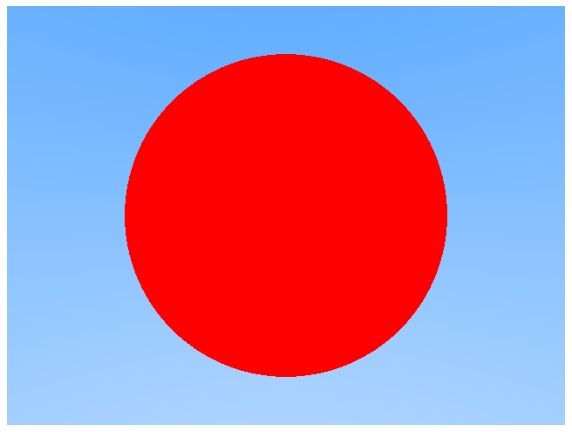

In [59]:
engine = RayMarchingEngine(max_steps=100, collision_tolerance=1e-3)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(engine.render(scene));

Nice! It worked! The sphere just looks like a circle though because we are just returning the color of the object at the collision point, resulting in a sphere that is the same color everywhere.

## Shaders

Let's now discuss how we can capture the light information we have encoded in the scene. We'll augment our ray marching engine with some *shaders*. Shaders are a pretty broad term in computer graphics, but for now, let's treat them as a kind of post-processor for our engine. After a ray has collided with an object, we will use information from the collision (including the normal, importantly) to generate the color.

Let's first define a `Shader` abstract class which will update a color given all the information about a collision.


In [60]:
class Shader:
  
  @abc.abstractmethod
  def update_color(self, base_color: Color, hit_ray: Ray, material: Material,
                   scene: Scene) -> Color:
    pass


Let's then define a `ShaderEngine`, which will allow us to pass in a list of `Shaders`s that will iteratively update the color.

In [61]:
@dataclasses.dataclass
class ShaderEngine(RayMarchingEngine):
  shaders: List[Shader]

  def color_at(self, ray: Ray, scene: Scene) -> Color:
    hit_normal = scene.obj.normal(ray.point)
    base_color = jnp.array([0., 0., 0.])
    material = scene.obj.material_at(ray.point)
    hit_ray = Ray(ray.point, hit_normal)
    for shader in self.shaders:
      base_color = base_color + shader.update_color(base_color, hit_ray,
                                                    material, scene)
    return base_color


### Lambert shading

Let's write our first shader which implements [Lambertian reflectance](https://en.wikipedia.org/wiki/Lambertian_reflectance). One problem with our last image is that we didn't take into account the position of the light relative to our object. When light hits an object, it often scatters in a phenomenon called *diffuse reflection*. Some of this scattered light will then be captured by the camera and is often responsible for the color of the object we actually observe.

<center>

| <img src='https://upload.wikimedia.org/wikipedia/commons/b/bd/Lambert2.gif' width='400px'/> |
|:--:| 
| Diffuse and specular reflection. Image from [Wikipedia](https://en.wikipedia.org/wiki/Diffuse_reflection).|

</center>

An ideal diffuse surface obeys the Lambert cosine law, where the intensity of the scattered light is highest at the normal vector the object and falls off as the light is more parallel to the object's surface. Specifically, if we have an incident light ray with intensity $I_i$ impacting an object at a point with normal vector $n$, a given scattered light ray $l$ (with unit direction) has its intensity $I_l$ is given by:
$$
I_l = (l \cdot n) I_i
$$

The dot product computes the cosine of the angle between the scattered light and the object normal, so when they are at 90 degrees from each other, the output intensity is 0. 

To implement this, let's write a `LambertShader` that computes the scattered light going in the direction of the camera for each light source. We'll scale the object's color byt eh resulting intensity. We'll also scale the intensity by `material.diffuse`, which captures a general reduction intensity specific to the material.

In [99]:
class LambertShader(Shader):

  def update_color(self, base_color: Color, hit_ray: Ray, material: Material,
                   scene: Scene) -> Color:
    obj_color = material.color
    # First compute vectors pointing from the object towards light sources
    # for incident light information
    light_directions = jnp.array([
      Ray(hit_ray.point, light.point).normalize().direction
      for light in scene.lights
    ])
    # We now take a dot product between the object normal and the light
    # direction. We also take a max here incase the dot product is negative
    # (i.e. the angle is more than 90 degrees).
    lambert = vmap(lambda light_ray: obj_color * material.diffuse * jnp.maximum(
      hit_ray.direction.dot(light_ray), 0.
    ))(light_directions)
    # We add diffuse scattering from all lights to the current color
    return base_color + jnp.sum(lambert, axis=0)

Let's now try rendering with a Lambert shader.

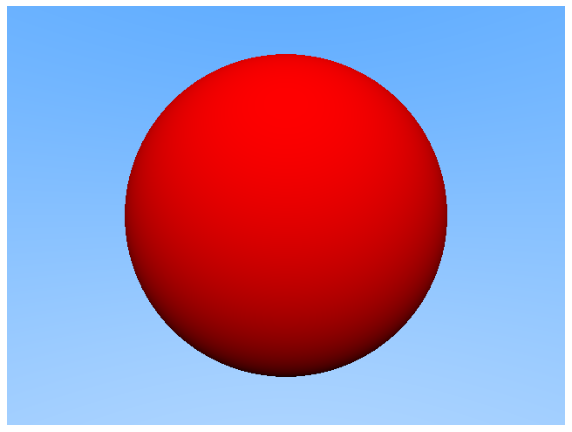

In [100]:
engine = ShaderEngine(max_steps=100, collision_tolerance=1e-3,
                      shaders=[LambertShader()])
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(engine.render(scene));

### Blinn-Phong Shading

Another type of light reflection we'd like to model is *specular reflectance*, where light bounces off a reflective surface as if it were a mirror. If an object has such reflective properties, we expect to see reflections of the light sources on its surface.

<center>

| <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Blinn_Vectors.svg/1280px-Blinn_Vectors.svg.png' width="400px"/> |
|:--:| 
| The angles in the Blinn-Phong reflection model. Image from [Wikipedia](https://en.wikipedia.org/wiki/Blinn%E2%80%93Phong_reflection_model).|

</center>

We'll implement the Blinn-Phong reflection model which first computes a *halfway vector* $H$, or the unit vector that points halfway between the light source vector $L$ and camera ray $V$. We can compute $H$ 
$$
H = \frac{L + V}{\|L + V\|_2}
$$
We are interested in the angle between the halfway vector and the surface normal, which we can compute with another dot product. Intuitively, we expect the smaller the angle is between $N$ and $L$ the more intense specular reflection we will observe. We then raise this angle to a power $\alpha$ (which we will call `hardness`) which will make the intensity fall off faster as the angle gets smaller. We compute a color value by adding in the light's color itself.

Let's now implement the `BlinnPhongShader`.

In [109]:
@dataclasses.dataclass
class BlinnPhongShader(Shader):
  hardness: float
  
  def update_color(self, base_color: Color, hit_ray: Ray, material: Material,
                   scene: Scene) -> Color:
    camera_direction = (jnp.array([0., 0., -scene.camera_distance])
                        - hit_ray.point)
    # Compute normalized light direction vectors
    light_directions = jnp.array([
      Ray(hit_ray.direction, light.point).normalize().direction for light in scene.lights
    ])
    # Halfway vectors are computed by normalizing the sum of our light rays
    # and the vector to the camera
    half_vecs = vmap(lambda light_ray: normalize(light_ray + camera_direction))(
        light_directions)
    specular = jnp.array([light.color * material.specular * jnp.maximum(
      hit_ray.direction.dot(half_vec), 0.
    ) ** self.hardness for light, half_vec in zip(scene.lights, half_vecs)])
    return base_color + jnp.sum(specular, axis=0)

Now let's put it all together!

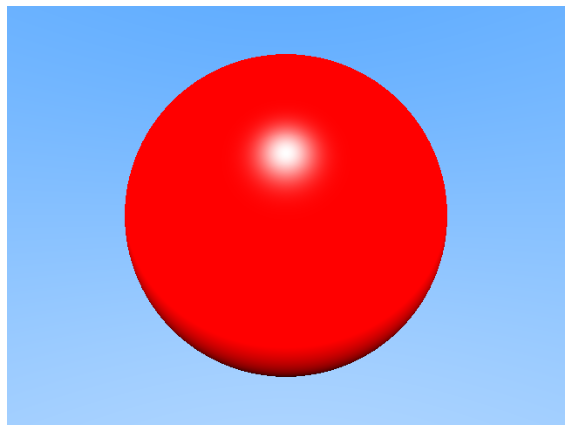

In [110]:
engine = ShaderEngine(max_steps=100, collision_tolerance=1e-3,
                      shaders=[LambertShader(), BlinnPhongShader(100.)])
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(engine.render(scene));

Playing around with the various parameters of the material, we can obtain variations of the same scene.

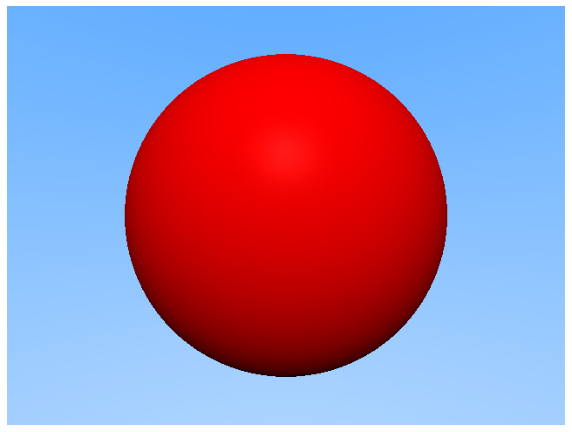

In [112]:
sphere = Sphere(0.5, material=Material(diffuse=0.5, specular=0.1))
scene = Scene(sphere, [Light(point=jnp.array([0., 1., -2.]), color=jnp.array([1., 1., 1.]))])
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(engine.render(scene));